## call "~/.local/bin/poetry" if poetry keyword not working on mac

In [2]:
import datetime
import geopandas
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [5]:
#local scripts

from scripts import veg_indices, utilities, plots
#from scripts.utilities import *

In [6]:
# cpied from learning_about-data.ipynb
BANDS_DICT = {   'B2': 'Blue',
            'B3': 'Green',
            'B4': 'Red',
            'B5': 'Red_Edge_1',
            'B6': 'Red_Edge_2',
            'B7': 'Red_Edge_3',
            'B8': 'NIR',
            'B8A': 'Red_Edge_4',
            'B11': 'SWIR_1',
            'B12': 'SWIR_2'}

BANDS = list(BANDS_DICT.keys())

In [7]:
# cpied from learning_about-data.ipynb
DF = geopandas.read_file('../data/merged_images_train.geojson')
DF.rename(columns = {'is_within_period':'har_evnt'}, inplace = True)
NUM_SAMPLES = len(np.unique(DF.image_idx)) - 1

In [8]:
DF

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,NDVI,finHarvDat,lat,lon,point_idx,start_date,end_date,har_evnt,image_idx,geometry
0,0.26430,0.21070,0.03560,0.05230,0.09150,0.12250,0.12680,0.13400,0.14440,0.1570,0.224248,2022-06-13,46.278183,28.990823,p1,2022-01-08,2022-01-28,False,i0,POINT (28.99082 46.27818)
1,0.13920,0.12250,0.29960,0.33210,0.34830,0.37580,0.38330,0.38140,0.39870,0.3801,0.067470,2022-06-13,49.455416,38.596773,p3,2022-01-08,2022-01-28,False,i0,POINT (38.59677 49.45542)
2,0.22250,0.18860,0.01300,0.03090,0.05410,0.08240,0.12350,0.14240,0.17000,0.1612,0.517180,2022-06-13,46.038067,29.720361,p6,2022-01-08,2022-01-28,False,i0,POINT (29.72036 46.03807)
3,0.08820,0.04740,0.07120,0.10060,0.08610,0.17570,0.35910,0.40780,0.46320,0.4427,0.686510,2022-06-13,47.036835,37.220923,p7,2022-01-08,2022-01-28,False,i0,POINT (37.22092 47.03684)
4,0.24140,0.19640,0.04430,0.05510,0.06840,0.09810,0.14670,0.16530,0.18780,0.1841,0.466042,2022-06-13,45.822236,29.873857,p8,2022-01-08,2022-01-28,False,i0,POINT (29.87386 45.82224)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35551,0.13555,0.11645,0.05460,0.05095,0.06040,0.06850,0.07815,0.07890,0.09510,0.0892,0.223151,2022-10-19,48.834525,37.110853,p2897,2022-12-10,2022-12-30,False,i16,POINT (37.11085 48.83452)
35552,0.16580,0.13260,0.03090,0.04300,0.06240,0.06640,0.07460,0.08300,0.09760,0.0987,0.220000,2022-06-13,45.791498,29.217956,p2899,2022-12-10,2022-12-30,False,i16,POINT (29.21796 45.79150)
35553,0.34870,0.30010,0.23780,0.25430,0.25415,0.28650,0.34235,0.34855,0.40410,0.3588,0.227801,2022-07-11,48.996343,37.568949,p2906,2022-12-10,2022-12-30,False,i16,POINT (37.56895 48.99634)
35554,0.23415,0.17295,0.07150,0.07540,0.10760,0.12590,0.13080,0.13755,0.15300,0.1548,0.174213,2022-07-11,49.315750,37.414231,p2913,2022-12-10,2022-12-30,False,i16,POINT (37.41423 49.31575)


In [42]:
# cpied from learning_about-data.ipynb
df = DF.copy()
df = df[(df.NDVI) != 0] # drop invalid points
VEG_INDICES_NAMES = veg_indices.add_veg_indices(df) + ['NDVI'] 
df, VEG_DIFF_NAMES = veg_indices.get_added_veg_diff(df, VEG_INDICES_NAMES)
NUMERIC_COLS = BANDS + VEG_INDICES_NAMES + VEG_DIFF_NAMES

df = utilities.get_drop_after_harvest(df)# drop rows of non-harvest, after a harvest event in a farm ( a point )
df = utilities.get_drop_after_finHarDat(df)

# for some reason, around 26 rows have same values for B4 & B5, making MTCI give infinite values
df = df.mask(df["MTCI"] == np.inf, np.nan).mask(df["MTCI"] == -np.inf, np.nan).dropna(subset=["MTCI"], axis=0)
df = df.mask(df["MTCI_diff"] == np.inf, np.nan).mask(df["MTCI_diff"] == -np.inf, np.nan).dropna(subset=["MTCI_diff"], axis=0)

df.reset_index(inplace=True)

print(df.columns, df.shape)

# For each 3-week image, standarize each column
#df = utilities.get_rm_outlier_standarize(df, NUMERIC_COLS, rm_outliers=False)

Added:  ['RVI', 'ARVI', 'PSSRa', 'NDI45', 'GNDVI', 'MCARI', 'IRECI', 'CIr', 'MTCI', 'NDVIre', 'NIRv', 'EVI', 'NDTI', 'NDMI', 'MSI', 'GCI', 'NBRI', 'BSI', 'NDWI', 'NDSI']
(not in place), created : ['RVI_diff', 'ARVI_diff', 'PSSRa_diff', 'NDI45_diff', 'GNDVI_diff', 'MCARI_diff', 'IRECI_diff', 'CIr_diff', 'MTCI_diff', 'NDVIre_diff', 'NIRv_diff', 'EVI_diff', 'NDTI_diff', 'NDMI_diff', 'MSI_diff', 'GCI_diff', 'NBRI_diff', 'BSI_diff', 'NDWI_diff', 'NDSI_diff', 'NDVI_diff']
Index(['index', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A',
       'NDVI', 'finHarvDat', 'lat', 'lon', 'point_idx', 'start_date',
       'end_date', 'har_evnt', 'image_idx', 'geometry', 'RVI', 'ARVI', 'PSSRa',
       'NDI45', 'GNDVI', 'MCARI', 'IRECI', 'CIr', 'MTCI', 'NDVIre', 'NIRv',
       'EVI', 'NDTI', 'NDMI', 'MSI', 'GCI', 'NBRI', 'BSI', 'NDWI', 'NDSI',
       'RVI_diff', 'ARVI_diff', 'PSSRa_diff', 'NDI45_diff', 'GNDVI_diff',
       'MCARI_diff', 'IRECI_diff', 'CIr_diff', 'MTCI_diff', 'NDVIre_diff',


In [31]:
%%script echo skipping

compression_opts = dict(method='zip',
                        archive_name='out_raw_bands.csv')
df.to_csv("dataframe_raw_bands.zip", index=True, compression=compression_opts)

skipping


#### metric0: Bhattacharyya Distance
- s6
    * RVI
    * NDVI
- s7
    * B12
    * B4
    * NDMI_diff
- s8
    * NDSI_diff
    * NDI45
- s9 
    * NDSI_diff
    * NBRI
    * BSI_diff
- ["RVI", "NDVI", "B12", "B4", "NDMI_diff", "NDSI_diff", "NDI45", "NDSI_diff", "NBRI", "BSI_diff"]



#### metric1: Hellinger Distance (same results as metric0!)
- s6
    * RVI
    * NDVI
- s7
    * B12
    * B4
    * NDMI_diff
- s8
    * NDSI_diff
    * NDI45
- s9 
    * NDSI_diff
    * NBRI
    * BSI_diff

    
#### metric2: Two-sample Kolmogorov Smirnov test P-Value
- s6
    * RVI
    * BSI_diff
- s7
    * NDVI
    * IRECI_diff
- s8
    * BSI_diff
    * NBRI
    * NBRI_diff
    * NDMI
    * ARVI
    * MSI_diff
- s9 
    * BSI_diff
    * IRECI_diff
- ["RVI", "BSI_diff", "NDVI", "IRECI_diff", "BSI_diff", "NBRI", "NBRI_diff", "NDMI", "ARVI", "MSI_diff"]


#### metric3: Jensen-Shannon Divergence (JSD) 
- s6
    * B6
    * NDVIre_diff
    * B2
- s7
    * ARVI_diff
    * B6
    * B7
    * B8A
- s8
    * B12
- s9 
    * MTCI
    * NDVIre_diff

- ["B6", "NDVIre_diff", "B2", "ARVI_diff", "B6", "B7", "B8A", "B12", "MTCI", "NDVIre_diff"]

In [43]:
def get_manually_selected():
    METRIC0 = ["RVI", "NDVI", "B12", "B4", "NDMI_diff", "NDSI_diff", "NDI45", "NDSI_diff", "NBRI", "BSI_diff"]
    METRIC1 = METRIC0
    METRIC2 = ["RVI", "BSI_diff", "NDVI", "IRECI_diff", "BSI_diff", "NBRI", "NBRI_diff", "NDMI", "ARVI", "MSI_diff"]
    METRIC3 = ["B6", "NDVIre_diff", "B2", "ARVI_diff", "B6", "B7", "B8A", "B12", "MTCI", "NDVIre_diff"]

    return np.unique(np.concatenate([METRIC0, METRIC1, METRIC2, METRIC3]))

def get_ordered_rdm_forests_features():
    # first one is the most important
    return ['B4', 'B5', 'B3', 'B2', 'B11', 'RVI', 'NDVIre', 'NDVI', 'NDSI', 'GNDVI',
       'NDWI', 'NDTI', 'GCI', 'ARVI', 'NBRI', 'B7', 'CIr', 'IRECI', 'MTCI',
       'MSI', 'PSSRa', 'NDI45', 'B12', 'B8', 'NDMI', 'BSI', 'NDTI_diff',
       'MSI_diff', 'MTCI_diff', 'NDMI_diff', 'NBRI_diff', 'NDWI_diff', 'NIRv',
       'CIr_diff', 'NDSI_diff', 'NDI45_diff', 'B6', 'RVI_diff', 'EVI',
       'GCI_diff', 'ARVI_diff', 'GNDVI_diff', 'NDVIre_diff', 'BSI_diff',
       'MCARI', 'PSSRa_diff', 'MCARI_diff', 'NDVI_diff', 'NIRv_diff',
       'EVI_diff', 'IRECI_diff', 'B8A']
    

#SELECTED_FEATURES = get_manually_selected()

SELECTED_FEATURES = NUMERIC_COLS
SELECTED_FEATURES = df[SELECTED_FEATURES].dropna(axis=1).columns


#SELECTED_FEATURES = get_ordered_rdm_forests_features()[:21 + 1] # get top 21 features

#SELECTED_FEATURES = ["NDVI", "NDVI_diff", "B2", "B3", "B4"]

print(SELECTED_FEATURES)

def get_X_y(dataframe: pd.DataFrame):
    df_X = dataframe[SELECTED_FEATURES]
    df_X = df_X.dropna(axis=1)
    X = df_X.to_numpy().reshape((df_X.shape[0], df_X.shape[1], 1))
    y = dataframe["har_evnt"].to_numpy().astype(np.float32)
    return X, y

Index(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'RVI',
       'ARVI', 'PSSRa', 'NDI45', 'GNDVI', 'MCARI', 'IRECI', 'CIr', 'MTCI',
       'NDVIre', 'NIRv', 'EVI', 'NDTI', 'NDMI', 'MSI', 'GCI', 'NBRI', 'BSI',
       'NDWI', 'NDSI', 'NDVI', 'RVI_diff', 'ARVI_diff', 'PSSRa_diff',
       'NDI45_diff', 'GNDVI_diff', 'MCARI_diff', 'IRECI_diff', 'CIr_diff',
       'MTCI_diff', 'NDVIre_diff', 'NIRv_diff', 'EVI_diff', 'NDTI_diff',
       'NDMI_diff', 'MSI_diff', 'GCI_diff', 'NBRI_diff', 'BSI_diff',
       'NDWI_diff', 'NDSI_diff', 'NDVI_diff'],
      dtype='object')


# Random Upsampling (not used)

# Separate Train, Val datasets (based on points)

In [12]:
%%script echo skipping
from sklearn.model_selection import train_test_split

            
points_df_list = []
for p in  df['point_idx'].unique(): # ['p0','p1','p2','p3','p4', ...]
    curr_df = df[df["point_idx"] == p]
    points_df_list.append(curr_df)
len(points_df_list)

training_df_list, validation_df_list = train_test_split(points_df_list, train_size=0.8, random_state=42)

print(len(training_df_list))
print(len(validation_df_list))


# combine into two dataframes
train_df = pd.concat(training_df_list)
validate_df = pd.concat(validation_df_list)
train_df.shape, validate_df.shape

skipping


# Separate Train, Val datasets

In [44]:
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(df, train_size=0.8, random_state=42, stratify=df.har_evnt)

print(train_df.shape, validate_df.shape)
print(np.unique(train_df.har_evnt, return_counts=True))
print(np.unique(validate_df.har_evnt, return_counts=True))

(12260, 62) (3066, 62)
(array([False, True], dtype=object), array([11146,  1114]))
(array([False, True], dtype=object), array([2787,  279]))


In [45]:
#%%script echo skipping
def apply_random_upsampling(df):
    har_evnt_true_df = df[df["har_evnt"]]
    har_evnt_false_df = df[df["har_evnt"] == False]
    print(har_evnt_true_df.shape)
    print(har_evnt_false_df.shape)

    from sklearn.utils import resample

    upsampled_har_evnt_true_df = resample(har_evnt_true_df, n_samples=har_evnt_false_df.shape[0],
                                                    replace=True, random_state=42)
    print(upsampled_har_evnt_true_df.shape)

    return pd.concat([upsampled_har_evnt_true_df, har_evnt_false_df])
    print(df.shape)

train_df = apply_random_upsampling(train_df)

(1114, 62)
(11146, 62)
(11146, 62)


# Convert to Numpy

In [63]:
X_train, y_train = get_X_y(train_df)
print(X_train.shape, y_train.shape)
X_validate, y_validate = get_X_y(validate_df)
print(X_validate.shape, y_validate.shape)


(22292, 52, 1) (22292,)
(3066, 52, 1) (3066,)


# SMOTE Upsampling

In [ ]:
%%script echo skipping

import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter

def upsample(X, y):
    print(X.shape)
    # oversampling the train dataset using SMOTE
    smt = SMOTE()
    counter = Counter(y)
    print('Before',counter)
    X = X.reshape(X.shape[0], X.shape[1]) # remove last dim in (6678, 21, 1)
    X, y = smt.fit_resample(X, y)
    X_sm, y_sm = smt.fit_resample(X, y)

    counter = Counter(y_sm)
    print('After',counter)

    X = X.reshape(X.shape[0], X.shape[1], 1)
    print("")
    return X, y

X_train, y_train = upsample(X_train, y_train)


In [64]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
model = tf.keras.Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    BatchNormalization(),
    Dense(units=32, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=8, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

#model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 batch_normalization (BatchN  (None, 800)              3200      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                25632     
                                                                 
 dense_1 (Dense)             (None, 64)                2

In [66]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])


In [67]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_validate, y_validate))


Epoch 1/20


2023-05-22 16:12:19.954862: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


697/697 [==============================] - 2s 2ms/step - loss: 0.3014 - binary_accuracy: 0.8717 - val_loss: 0.3355 - val_binary_accuracy: 0.8226
Epoch 2/20
697/697 [==============================] - 1s 1ms/step - loss: 0.2426 - binary_accuracy: 0.9020 - val_loss: 0.2638 - val_binary_accuracy: 0.8627
Epoch 3/20
697/697 [==============================] - 1s 2ms/step - loss: 0.2150 - binary_accuracy: 0.9142 - val_loss: 0.2836 - val_binary_accuracy: 0.8816
Epoch 4/20
697/697 [==============================] - 1s 2ms/step - loss: 0.1990 - binary_accuracy: 0.9241 - val_loss: 0.2013 - val_binary_accuracy: 0.9178
Epoch 5/20
697/697 [==============================] - 1s 2ms/step - loss: 0.1841 - binary_accuracy: 0.9306 - val_loss: 0.1811 - val_binary_accuracy: 0.9191
Epoch 6/20
697/697 [==============================] - 1s 1ms/step - loss: 0.1776 - binary_accuracy: 0.9353 - val_loss: 0.2772 - val_binary_accuracy: 0.8813
Epoch 7/20
697/697 [==============================] - 1s 2ms/step - loss: 0

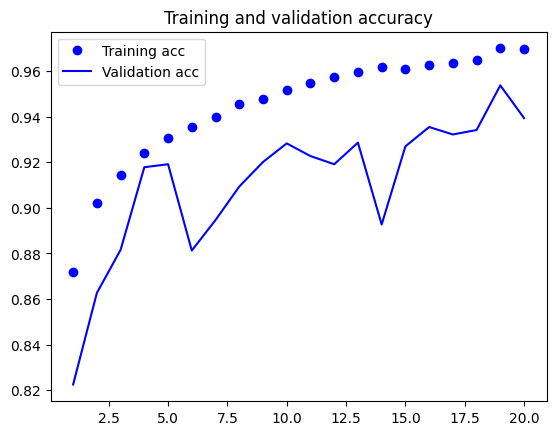

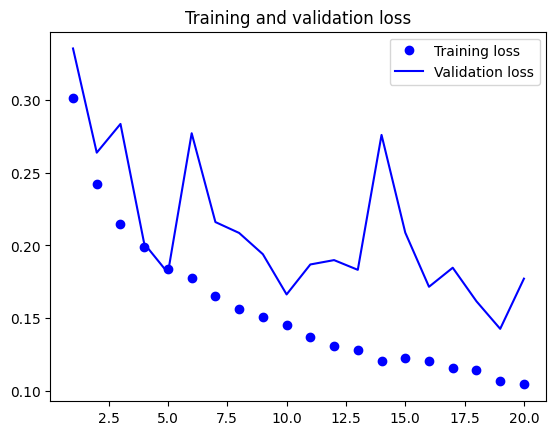

In [68]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [69]:
import sklearn
func = np.vectorize(lambda x: 0 if x < 0.5 else 1)

In [50]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

def plot_confusion_matrix(actual, predicted):
    confusion_matrix = metrics.confusion_matrix(actual, predicted)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()

In [ ]:
print("X_train")
y_predict = np.array(list(model.predict(X_train)))
y_predict = y_predict.reshape(y_predict.shape[0])
print(np.unique(func(y_predict), return_counts=True))
print(sklearn.metrics.classification_report(y_train, func(y_predict)))
plot_confusion_matrix(y_train, func(y_predict))

In [ ]:
print("X_validate")

y_predict = np.array(list(model.predict(X_validate)))
y_predict = y_predict.reshape(y_predict.shape[0])
print(np.unique(func(y_predict), return_counts=True))
print(sklearn.metrics.classification_report(y_validate, func(y_predict)))
plot_confusion_matrix(y_validate, func(y_predict))

In [47]:
def rm_extradim(X, y):
    X, y = X.reshape(X.shape[0], X.shape[1]), y.reshape(y.shape[0])
    return X, y

# Random Forests Feature Selection

In [48]:

X_train, y_train = rm_extradim(X_train, y_train)
X_validate, y_validate = rm_extradim(X_validate, y_validate)

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier()

rf.fit(X_train, y_train)
y_predict = rf.predict(X_validate)


accuracy_score(y_validate, y_predict)

0.9755381604696673

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99      2787
         1.0       0.79      0.99      0.88       279

    accuracy                           0.98      3066
   macro avg       0.90      0.98      0.93      3066
weighted avg       0.98      0.98      0.98      3066



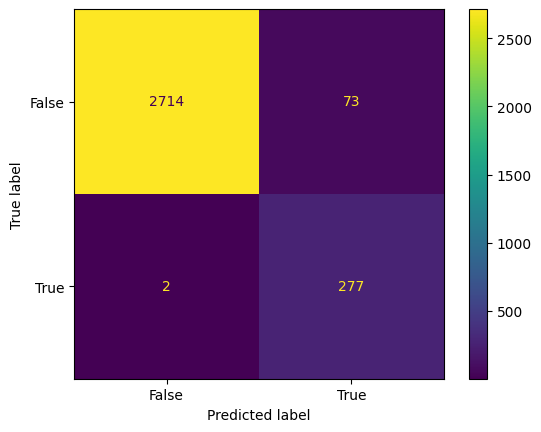

In [53]:
print(sklearn.metrics.classification_report(y_validate, y_predict))

plot_confusion_matrix(y_validate, func(y_predict))

In [54]:
np.unique(y_train, return_counts=True)

(array([0., 1.], dtype=float32), array([11146, 11146]))

In [55]:
feature_importances_df = pd.DataFrame(rf.feature_importances_,
                    index=SELECTED_FEATURES, 
                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances_df

,importance
B5,0.077575
RVI_diff,0.069530
B4,0.060193
EVI_diff,0.056233
ARVI_diff,0.048315
ARVI,0.042449
B3,0.040701
B2,0.036028
NDVI_diff,0.031389
NDWI_diff,0.029093


In [56]:
feature_importances_df.T.columns

Index(['B5', 'RVI_diff', 'B4', 'EVI_diff', 'ARVI_diff', 'ARVI', 'B3', 'B2',
       'NDVI_diff', 'NDWI_diff', 'GNDVI_diff', 'IRECI_diff', 'NDVIre_diff',
       'GCI_diff', 'CIr_diff', 'BSI_diff', 'PSSRa_diff', 'B11', 'NDSI', 'MTCI',
       'NDTI', 'MSI_diff', 'NDI45_diff', 'NDMI_diff', 'B8', 'NDVIre', 'B6',
       'B7', 'MCARI_diff', 'NDI45', 'MTCI_diff', 'B12', 'NDSI_diff',
       'NIRv_diff', 'MCARI', 'B8A', 'NIRv', 'GNDVI', 'GCI', 'NDTI_diff',
       'NBRI_diff', 'NDMI', 'NDVI', 'NDWI', 'BSI', 'NBRI', 'MSI', 'CIr',
       'IRECI', 'RVI', 'EVI', 'PSSRa'],
      dtype='object')

In [57]:
sorted(get_manually_selected())

['ARVI',
 'ARVI_diff',
 'B12',
 'B2',
 'B4',
 'B6',
 'B7',
 'B8A',
 'BSI_diff',
 'IRECI_diff',
 'MSI_diff',
 'MTCI',
 'NBRI',
 'NBRI_diff',
 'NDI45',
 'NDMI',
 'NDMI_diff',
 'NDSI_diff',
 'NDVI',
 'NDVIre_diff',
 'RVI']

In [41]:
for arr in X_train:
    if(min(arr) == -np.inf):
        print(arr)

[ 4.27500000e-02  6.20000000e-02  5.44000000e-02  8.75000000e-02
  1.56550000e-01  1.74250000e-01  1.85400000e-01  1.82050000e-01
  1.95200000e-01  1.46000000e-01  2.93419633e-01  1.13410072e+00
  3.20312500e+00  2.33262861e-01  4.98787389e-01  9.26800000e-04
  2.14428771e-01  9.91428571e-01  2.08610272e+00  3.58739465e-01
  2.97180984e-02  2.74938611e-01  1.44196952e-01 -2.57488177e-02
  1.05285868e+00  1.99032258e+00  1.18889559e-01  4.48979592e-02
 -4.98787389e-01 -5.17884914e-01  5.46288550e-01 -4.13185590e-01
 -2.86899782e-02  2.13355978e+00  2.33262861e-01  2.57605311e-01
  9.26800000e-04  2.11180076e-01  9.21863354e-01            -inf
  1.86822273e-01  2.18099076e-02  2.28707309e-01  3.70718897e-02
  2.35318152e-01 -6.53746539e-01  1.35464419e+00  2.77260600e-01
 -1.48417650e-01 -2.57605311e-01 -4.53865712e-02  3.74371360e-01]
[ 4.27500000e-02  6.20000000e-02  5.44000000e-02  8.75000000e-02
  1.56550000e-01  1.74250000e-01  1.85400000e-01  1.82050000e-01
  1.95200000e-01  1.4600

In [ ]:
np.amin(df[NUMERIC_COLS])

In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
sorted()

In [ ]:
sorted(df[NUMERIC_COLS].shape)

In [ ]:
df.where(df["MTCI"] == np.inf).head()["har_evnt"]

In [ ]:
DF.where(DF["B2"] == np.nan).head()

In [ ]:
df[(df["MTCI"] == -np.inf)]

In [ ]:
df.shape

In [19]:
a = df.mask(df["MTCI"] == np.inf, np.nan).mask(df["MTCI"] == -np.inf, np.nan).dropna(subset=["MTCI"], axis=0)

In [28]:
df[df["B2"].isna()]

,index,B11,B12,B2,B3,B4,B5,B6,B7,B8,...,EVI_diff,NDTI_diff,NDMI_diff,MSI_diff,GCI_diff,NBRI_diff,BSI_diff,NDWI_diff,NDSI_diff,NDVI_diff


In [40]:
np.amin(X_train)

-inf

In [ ]:
a.dropna(subset=["MTCI"], axis=0)

In [32]:
df[NUMERIC_COLS].dropna(axis=0)

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,...,EVI_diff,NDTI_diff,NDMI_diff,MSI_diff,GCI_diff,NBRI_diff,BSI_diff,NDWI_diff,NDSI_diff,NDVI_diff
0,0.02300,0.02600,0.03230,0.04200,0.05760,0.06220,0.0457,0.07100,0.07550,0.07860,...,-0.079809,-0.087723,0.006784,-0.024073,-0.819723,-0.076415,-0.036317,0.166181,0.136385,-0.149208
1,0.28290,0.26640,0.26640,0.27720,0.28800,0.28810,0.3728,0.29660,0.37630,0.29575,...,0.281747,0.139974,0.241202,-0.642690,-0.358293,0.379932,-0.231542,0.108298,0.316687,-0.005337
2,0.05910,0.07630,0.08210,0.11670,0.17650,0.19370,0.1984,0.20860,0.24190,0.20290,...,-0.080124,-0.032177,-0.094124,0.209866,1.200863,-0.126463,0.124372,-0.278027,-0.349430,0.248159
3,0.04930,0.07620,0.06440,0.10910,0.21510,0.25480,0.2688,0.26560,0.21940,0.15260,...,0.164507,0.091890,0.199984,-0.403034,0.927297,0.286961,-0.171346,-0.113776,0.035989,0.198829
4,0.04515,0.07555,0.06530,0.11885,0.24055,0.27490,0.2810,0.29145,0.18055,0.11755,...,0.006656,0.031769,0.116448,-0.173694,0.191832,0.134364,-0.083398,-0.017956,0.074442,0.009425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15329,0.06380,0.10590,0.09250,0.18265,0.30590,0.34155,0.3482,0.36110,0.21285,0.14305,...,-0.063330,0.010076,-0.071292,0.087519,-0.333672,-0.053577,0.083797,0.033674,-0.025918,-0.072551
15330,0.08100,0.11360,0.15540,0.19950,0.23225,0.25395,0.2726,0.28880,0.31570,0.22730,...,-0.265279,-0.033323,-0.314506,0.546820,-0.888360,-0.326990,0.291148,0.121879,-0.135237,-0.306382
15331,0.02270,0.03740,0.04200,0.06600,0.10440,0.11340,0.1224,0.12700,0.15420,0.11720,...,0.006840,-0.051807,-0.069290,0.164077,-0.278107,-0.121992,0.036754,0.028605,-0.018539,-0.017710
15332,0.02490,0.04345,0.05275,0.07810,0.11960,0.12975,0.1429,0.14600,0.20700,0.18055,...,0.010168,-0.068081,-0.068228,0.188762,0.016110,-0.138104,0.065341,-0.001758,-0.043421,-0.028279


In [23]:
df[NUMERIC_COLS]

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,...,EVI_diff,NDTI_diff,NDMI_diff,MSI_diff,GCI_diff,NBRI_diff,BSI_diff,NDWI_diff,NDSI_diff,NDVI_diff
0,0.02300,0.02600,0.03230,0.04200,0.05760,0.06220,0.0457,0.07100,0.07550,0.07860,...,-0.079809,-0.087723,0.006784,-0.024073,-0.819723,-0.076415,-0.036317,0.166181,0.136385,-0.149208
0,0.28290,0.26640,0.26640,0.27720,0.28800,0.28810,0.3728,0.29660,0.37630,0.29575,...,0.281747,0.139974,0.241202,-0.642690,-0.358293,0.379932,-0.231542,0.108298,0.316687,-0.005337
0,0.05910,0.07630,0.08210,0.11670,0.17650,0.19370,0.1984,0.20860,0.24190,0.20290,...,-0.080124,-0.032177,-0.094124,0.209866,1.200863,-0.126463,0.124372,-0.278027,-0.349430,0.248159
0,0.04930,0.07620,0.06440,0.10910,0.21510,0.25480,0.2688,0.26560,0.21940,0.15260,...,0.164507,0.091890,0.199984,-0.403034,0.927297,0.286961,-0.171346,-0.113776,0.035989,0.198829
0,0.04515,0.07555,0.06530,0.11885,0.24055,0.27490,0.2810,0.29145,0.18055,0.11755,...,0.006656,0.031769,0.116448,-0.173694,0.191832,0.134364,-0.083398,-0.017956,0.074442,0.009425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2343,0.06380,0.10590,0.09250,0.18265,0.30590,0.34155,0.3482,0.36110,0.21285,0.14305,...,-0.063330,0.010076,-0.071292,0.087519,-0.333672,-0.053577,0.083797,0.033674,-0.025918,-0.072551
2756,0.08100,0.11360,0.15540,0.19950,0.23225,0.25395,0.2726,0.28880,0.31570,0.22730,...,-0.265279,-0.033323,-0.314506,0.546820,-0.888360,-0.326990,0.291148,0.121879,-0.135237,-0.306382
1815,0.02270,0.03740,0.04200,0.06600,0.10440,0.11340,0.1224,0.12700,0.15420,0.11720,...,0.006840,-0.051807,-0.069290,0.164077,-0.278107,-0.121992,0.036754,0.028605,-0.018539,-0.017710
1951,0.02490,0.04345,0.05275,0.07810,0.11960,0.12975,0.1429,0.14600,0.20700,0.18055,...,0.010168,-0.068081,-0.068228,0.188762,0.016110,-0.138104,0.065341,-0.001758,-0.043421,-0.028279
